In [58]:
import os

import matplotlib.pylab as plt
import pandas as pd
import torch
import torch.nn.functional as functional
import torch.optim as optim
from pytorch_transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [59]:
train_df = pd.read_csv("../data/nlp/bert/training.txt", sep="\t")
valid_df = pd.read_csv("../data/nlp/bert/validating.txt", sep="\t")
test_df = pd.read_csv("../data/nlp/bert/testing.txt", sep="\t")

train_df = train_df.sample(frac=0.1, random_state=500)
valid_df = valid_df.sample(frac=0.1, random_state=500)
test_df = test_df.sample(frac=0.1, random_state=500)

In [60]:
class BertDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sentence = self.df.iloc[idx, 1]
        label = self.df.iloc[idx, 2]
        return sentence, label

In [61]:
train_dataset = BertDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)

valid_dataset = BertDataset(valid_df)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=True, num_workers=0)

test_dataset = BertDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0)

In [62]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [63]:
def save_ckpt(save_path, _model, valid_loss):
    if not os.path.exists(save_path):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    save_dict = {'model_state_dict': _model.state_dict(),
                 'valid_loss': valid_loss}

    torch.save(save_dict, os.path.join(save_path, "bert-trained.pt"))
    print(f"Model saved to ==> {save_path}")


def load_ckpt(load_path, _model):
    if not os.path.exists(load_path):
        raise ValueError("File doesn't exist {}".format(load_path))

    state_dict = torch.load(load_path, map_location='cpu')
    print(f"Model loaded from <== {load_path}")

    _model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, _train_loss_list, _valid_loss_list, _global_steps_list):
    if not os.path.exists(save_path):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    save_dict = {'train_loss_list': _train_loss_list,
                 'valid_loss_list': _valid_loss_list,
                 'global_steps_list': _global_steps_list}

    torch.save(save_dict, os.path.join(save_path, "bert-metrics.pt"))
    print(f"Metrics saved to ==> {save_path}")


def load_metrics(load_path):
    if not os.path.exists(load_path):
        raise ValueError("File doesn't exist {}".format(load_path))

    state_dict = torch.load(load_path, map_location='cpu')
    print(f"Metrics loaded from <== {load_path}")

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [71]:
def train(_model,
          _optimizer,
          epochs=5,
          eval_every=len(train_loader) // 2,
          best_valid_loss=float("Inf")):
    total_correct = 0

    total_len = 0
    running_loss = 0
    valid_running_loss = 0

    global_step = 0

    _train_loss_list = []
    _valid_loss_list = []
    _global_steps_list = []

    save_path = "./ckpt/"
    
    if os.path.exists(os.path.join(save_path, "bert-trained.pt")):
        best_valid_loss = load_ckpt(os.path.join(save_path, "bert-trained.pt"), _model)

    if os.path.exists(os.path.join(save_path, "bert-metrics.pt")):
        _train_loss_list, _valid_loss_list, _global_steps_list = load_metrics(
            os.path.join(save_path, "bert-metrics.pt"))
    else:
        _train_loss_list = []
        _valid_loss_list = []
        _global_steps_list = []

    _model.train()
    for epoch in range(epochs):
        if global_step % eval_every == 0:
            save_ckpt(save_path, _model, best_valid_loss)
            save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list)

        for text, label in train_loader:
            _optimizer.zero_grad()

            encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
            padded_list = [e[:512] + [0] * (512 - len(e[:512])) for e in encoded_list]

            sample = torch.tensor(padded_list)
            sample, label = sample.to(device), label.to(device)

            labels = torch.tensor(label)

            outputs = _model(sample, labels=labels)
            loss, logits = outputs

            pred = torch.argmax(functional.softmax(logits), dim=1)
            correct = pred.eq(labels)
            total_correct += correct.sum().item()
            total_len += len(labels)

            running_loss += loss.item()
            loss.backward()
            _optimizer.step()
            global_step += 1

            if global_step % eval_every == 0:
                _model.eval()
                with torch.no_grad():
                    for _text, _label in valid_loader:
                        encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in _text]
                        padded_list = [e[:512] + [0] * (512 - len(e[:512])) for e in encoded_list]
                        sample = torch.tensor(padded_list)
                        sample, _label = sample.to(device), _label.to(device)
                        labels = torch.tensor(_label)
                        outputs = _model(sample, labels=labels)
                        loss, logits = outputs
                        valid_running_loss += loss.item()

                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                _train_loss_list.append(average_train_loss)
                _valid_loss_list.append(average_valid_loss)
                _global_steps_list.append(global_step)

                running_loss = 0
                valid_running_loss = 0
                _model.train()

                print(
                    f"Epoch [{epoch + 1}/{epochs}] | Step [{global_step}/{epochs * len(train_loader)}] | Train Loss: {average_train_loss} | Valid Loss: {average_valid_loss}")

                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_ckpt(save_path, _model, best_valid_loss)
                    save_metrics(save_path, _train_loss_list, _valid_loss_list, _global_steps_list)

    save_metrics(save_path, _train_loss_list, _valid_loss_list, _global_steps_list)
    print("Training finished")

In [72]:
optimizer = optim.Adam(model.parameters(), lr=2e-5)
train(model, optimizer)

Model loaded from <== ./ckpt/bert-trained.pt
Metrics loaded from <== ./ckpt/bert-metrics.pt
Model saved to ==> ./ckpt/
Metrics saved to ==> ./ckpt/


C:\Users\PleahMaCaka\AppData\Local\Temp\ipykernel_37216\3530581389.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)
C:\Users\PleahMaCaka\AppData\Local\Temp\ipykernel_37216\3530581389.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(functional.softmax(logits), dim=1)
C:\Users\PleahMaCaka\AppData\Local\Temp\ipykernel_37216\3530581389.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)


Epoch [1/5] | Step [510/5100] | Train Loss: 0.6981619655501609 | Valid Loss: 0.6926242306843355
Model saved to ==> ./ckpt/
Metrics saved to ==> ./ckpt/
Epoch [1/5] | Step [1020/5100] | Train Loss: 0.7004907133532505 | Valid Loss: 0.6934326232846452
Model saved to ==> ./ckpt/
Metrics saved to ==> ./ckpt/


KeyboardInterrupt: 

Metrics loaded from <== ./ckpt/bert-metrics.pt


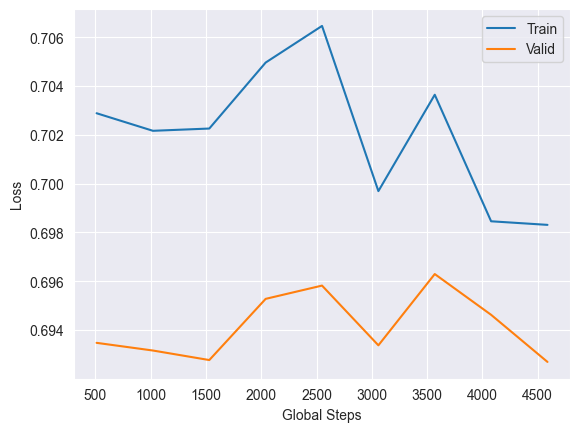

In [76]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics("./ckpt/bert-metrics.pt")
plt.plot(global_steps_list, train_loss_list, label="Train")
plt.plot(global_steps_list, valid_loss_list, label="Valid")
plt.xlabel("Global Steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("training.tmp.png")
plt.show()  # ?

In [78]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


def evaluate(_model, test_loader):
    y_pred = []
    y_true = []
    
    model.eval()
    with torch.no_grad():
        for text, label in test_loader:
            encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
            padded_list = [e[:512] + [0] * (512 - len(e[:512])) for e in encoded_list]
            sample = torch.tensor(padded_list)
            sample, label = sample.to(device), label.to(device)
            labels = torch.tensor(label)
            outputs = _model(sample, labels=labels)
            _, logits = outputs
            pred = torch.argmax(functional.softmax(logits), dim=1)
            y_pred.extend(pred.tolist())
            y_true.extend(label.tolist())
            
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])

Model loaded from <== ./ckpt/bert-trained.pt


C:\Users\PleahMaCaka\AppData\Local\Temp\ipykernel_37216\535000610.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)
C:\Users\PleahMaCaka\AppData\Local\Temp\ipykernel_37216\535000610.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(functional.softmax(logits), dim=1)


Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000       558
           0     0.4909    1.0000    0.6585       538

    accuracy                         0.4909      1096
   macro avg     0.2454    0.5000    0.3293      1096
weighted avg     0.2410    0.4909    0.3232      1096


C:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


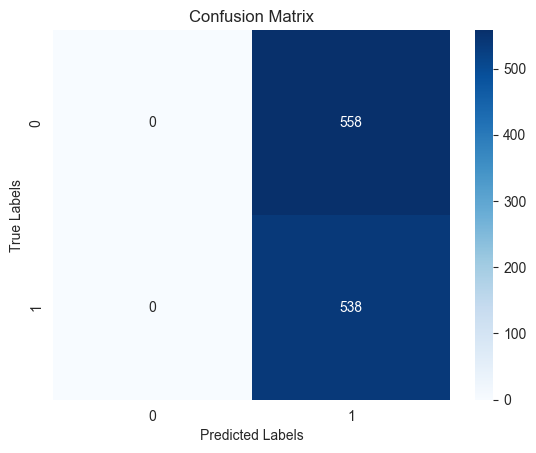

In [79]:
best_model = model.to(device)
load_ckpt("./ckpt/bert-trained.pt", best_model)
evaluate(best_model, test_loader)